# 2009 data expo project 2022

Year 2004 and 2005 will be used for python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calplot

Read in data

In [ ]:
dataset = pd.read_csv (r'C:\Users\limzy\dataverse files 0405\2004.csv')

### **DATA WRANGLING**

In [ ]:
dataset.head

In [ ]:
drop_columns=['ActualElapsedTime','CRSElapsedTime', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [ ]:
dataset.drop(columns=drop_columns,inplace=True)

Changing year,month,dayofmonth to datetime64

In [ ]:
dataset['dateInt']=dataset['Year'].astype(str) + dataset['Month'].astype(str).str.zfill(2) + dataset['DayofMonth'].astype(str).str.zfill(2)

dataset['Date'] = pd.to_datetime(dataset['dateInt'], format='%Y%m%d')

drop_columns=['Year','dateInt']

dataset.drop(columns=drop_columns,inplace=True)

Filling Nan Values for aircrafts missing a flight number

In [ ]:
dataset.TailNum.fillna('unidefined',inplace=True)

Moving Date column to the front

In [ ]:
col_name="Date"
first_col = dataset.pop(col_name)
dataset.insert(0, col_name, first_col)

Removing the entries with nan in ArrTime and Arrdelay variables

In [ ]:
dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

Changing to int

In [ ]:
dataset['ArrTime'] = dataset['ArrTime'].astype(np.int64)
dataset['DepTime'] = dataset['DepTime'].astype(np.int64)
dataset['ArrDelay'] = dataset['ArrDelay'].astype(np.int64)
dataset['DepDelay'] = dataset['DepDelay'].astype(np.int64)

dataset[['DepTime', 'ArrTime']].describe() # DepTime max: 2750, ArrTime max: 2955

Max of DepTime and ArrTime can only be 2400 therefore to treat this,
I will set the limit of time to 2400 and anything after will be nan

In [ ]:
dataset.DepTime.mask((dataset.DepTime >= 2400) & (dataset.DepTime <= 3000), inplace=True)
dataset.ArrTime.mask((dataset.ArrTime >= 2400) & (dataset.ArrTime <= 3000), inplace=True)

Removing the entries with nan in ArrTime and DepTime variables

In [ ]:
dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

### Detection and treatment of Outliers – IQR approach

In [ ]:
dataset[['ArrDelay'	,'DepDelay']].describe()

for x in ['ArrDelay']:
    q75,q25 = np.percentile(dataset.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dataset.loc[dataset[x] < min,x] = np.nan
    dataset.loc[dataset[x] > max,x] = np.nan
    
for x in ['DepDelay']:
    q75,q25 = np.percentile(dataset.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dataset.loc[dataset[x] < min,x] = np.nan
    dataset.loc[dataset[x] > max,x] = np.nan

dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

Insert departure and arrival status

In [ ]:
dep_conditions = [(dataset.DepDelay < 0),
                  (dataset.DepDelay == 0),
                  (dataset.DepDelay > 0)]
dep_values=['Early Departure','On Time','Late Departure']        
dataset['DepStatus']=np.select(dep_conditions,dep_values)

arr_conditions = [(dataset.ArrDelay < 0),
                  (dataset.ArrDelay == 0),
                  (dataset.ArrDelay > 0)]
arr_values=['Early Arrival','On Time','Late Arrival']        
dataset['ArrStatus']=np.select(arr_conditions,arr_values)

In [ ]:
del dep_conditions
del arr_conditions
del arr_values
del dep_values
del intr_qr
del max
del min
del q25
del q75
del x
del col_name
del first_col

## **QUESTION 1**

Dataframe for average daily flight delay for 2004

In [ ]:
flights_delayed = dataset[['Date','ArrDelay']].copy()

Finding the average daily flight delay for 2004

In [ ]:
meandelay2004 = flights_delayed.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='D', sort=True)).mean()

meandelay2004['ArrDelay'] = pd.to_numeric(pd.to_datetime(meandelay2004['ArrDelay']))

Plot Heatmap

In [ ]:
calplot.calplot(meandelay2004["ArrDelay"],linewidth=2.3,
cmap='coolwarm', suptitle=('Average daily flight delay'))

Resetting index as groupby function made 'Dates' into index

In [ ]:
meandelay2004 = meandelay2004.reset_index()

Finding the mean of the monthly delays

In [ ]:
monthlydelay = dataset[['Date','ArrDelay']].copy()
monthlydelay = monthlydelay.set_index('Date')
monthlydelay = monthlydelay.groupby(pd.Grouper(freq='M')).mean()

# Declare a month name list that is to be converted into a column
months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Using 'Months' as the column name
# and equating it to the dataframe
monthlydelay['Months'] = months

Bar plot for monthly mean delay

In [ ]:
monthlydelay.plot.bar(x="Months", y="ArrDelay", rot=70, title="Monthly Average of flight delay (in Mins) - Year 2004")

Sep - lowest average flight delay. Filter Sep

In [ ]:
Sep_Delay = meandelay2004.loc[(meandelay2004['Date'] >= '2004-09-01')
                     & (meandelay2004['Date'] < '2004-09-30')]

# Add days inside
Sep_Delay['Day'] = Sep_Delay.Date.dt.strftime("%A")

Plot bar

In [ ]:
Sep_Delay.plot.bar(x="Day", y="ArrDelay", rot=70, title="Sep Average of flight delay (in Mins) - Year 2004")

SEP 5 lowest average delay of month. Filter for Sep 5

In [ ]:
Sep_5 = dataset.loc[(dataset['Date'] == '2004-09-05')]

drop_columns=['Date','Month','DayOfWeek','ArrTime','UniqueCarrier','FlightNum','TailNum','DepDelay','Cancelled']

Sep_5.drop(columns=drop_columns,inplace=True)

Sep_5 = Sep_5.sort_values(by=['DepTime'])

Classifying time of the day

In [ ]:
def classify(x):
    if 0 <= x < 1200:
        y = "Morning"
    if 1200 <= x < 1800:
        y = "Afternoon"
    if 1800 <= x < 2400:
        y = "Evening"
    return y

Sep_5['TimeOfDay'] = Sep_5['DepTime'].apply(lambda x: classify(x))

In [ ]:
drop_columns=['DepTime']
Sep_5.drop(columns=drop_columns,inplace=True)

# Grouping values together according to time of the day and find the sum of the delay
Sep_5 = Sep_5.groupby(['TimeOfDay']).sum()     # -52263, -53390, -23822
# Negative delay indicates early arrival

Pie chart plot

In [ ]:
y = ["52263","53390","23822"]
mylabels = ["Morning","Afternoon","Evening"]
# To highlight the biggest portion of the piechart
myexplode = [0, 0.2, 0]
plt.pie(y, labels = mylabels, explode = myexplode)

In [ ]:
del y
del myexplode
del mylabels
del Sep_5
del Sep_Delay
del flights_delayed
del months
del monthlydelay
del meandelay2004

## **QUESTION 2**

Read in data

In [ ]:
planedata = pd.read_csv (r'C:\Users\limzy\dataverse files 0405\plane-data.csv')

plane_records = dataset[['ArrDelay','TailNum']].copy()

Sum of minutes of arrival delay grouped by plane tail number

In [ ]:
plane_delay = plane_records.groupby(['TailNum']).sum()

Merge dataframes by tail number

In [ ]:
combined_plane_delay = pd.merge(left=plane_delay, right=planedata, left_on='TailNum', right_on='tailnum')

combined_plane_delay.year = combined_plane_delay.year.astype('category')

combined_plane_delay = combined_plane_delay[['ArrDelay','tailnum','year']]
# Remove nan values
combined_plane_delay = combined_plane_delay.dropna()

Group planes according to their issued year and sum up their arrival delay in minutes

In [ ]:
combined_plane_delay = combined_plane_delay.groupby(['year']).sum()

combined_plane_delay = combined_plane_delay.reset_index()

Drop unknown year values by index('oooo', 'None'),  its strange to have year 2007 planes appearing in 2004 ('46')

In [ ]:
combined_plane_delay = combined_plane_delay.drop([0,46,47])

# Convert year to int
combined_plane_delay['year'] = combined_plane_delay['year'].astype(str).astype(int)
# To convert year(category) to int, it needs to be converted to str first 

Insert Plane age status

In [ ]:
plane_conditions = [(combined_plane_delay.year < 1993),
                  (combined_plane_delay.year >= 1993)]
plane_values=['OLD Plane','NEW Plane']        
combined_plane_delay['Plane_Age']=np.select(plane_conditions,plane_values)

Scatter plot

In [ ]:
g = sns.catplot(x="year", y="ArrDelay", hue="Plane_Age",  data=combined_plane_delay)
g.set_xticklabels(rotation=90)
g.fig.suptitle('2004 Arrival delay against age of plane')

In [ ]:
del g
del plane_conditions
del plane_delay
del plane_records
del plane_values
del planedata
del combined_plane_delay

## **QUESTION 3**

Split data into Quarters of a year

In [ ]:
origindep = dataset[['Date', 'Origin']]

Q1 = origindep.loc[(origindep.Date.dt.month==1) | (origindep.Date.dt.month==2) | (origindep.Date.dt.month==3)]
Q2 = origindep.loc[(origindep.Date.dt.month==4) | (origindep.Date.dt.month==5) | (origindep.Date.dt.month==6)]
Q3 = origindep.loc[(origindep.Date.dt.month==7) | (origindep.Date.dt.month==8) | (origindep.Date.dt.month==9)]
Q4 = origindep.loc[(origindep.Date.dt.month==10) | (origindep.Date.dt.month==11) | (origindep.Date.dt.month==12)]

Insert a new column and assign a value of 1(int)

In [ ]:
Q1.insert(2, "Count", 1, allow_duplicates=False)
Q2.insert(2, "Count", 1, allow_duplicates=False)
Q3.insert(2, "Count", 1, allow_duplicates=False)
Q4.insert(2, "Count", 1, allow_duplicates=False)

drop_columns=['Date']
Q1.drop(columns=drop_columns,inplace=True)
Q2.drop(columns=drop_columns,inplace=True)
Q3.drop(columns=drop_columns,inplace=True)
Q4.drop(columns=drop_columns,inplace=True)


Group by origin and find the top 10 highest count per origin

In [ ]:
Q1 = Q1.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q2 = Q2.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q3 = Q3.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q4 = Q4.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()

### Q1

In [ ]:
Q1.plot.bar(x = 'Origin', y = 'Count', color = 'blue',
            title = '2004 Q1 top 10 busiest US airport')

### Q2

In [ ]:
Q2.plot.bar(x = 'Origin', y = 'Count', color = 'green',
            title = '2004 Q2 top 10 busiest US airport')

### Q3

In [ ]:
Q3.plot.bar(x = 'Origin', y = 'Count', color = 'red',
            title = '2004 Q3 top 10 busiest US airport')

### Q4

In [ ]:
Q4.plot.bar(x = 'Origin', y = 'Count', color = 'orange',
            title = '2004 Q4 top 10 busiest US airport')

In [ ]:
del Q1
del Q2
del Q3
del Q4
del origindep

## **QUESTION 4**

Finding the top 3 planes with the highest sum of delay 

In [ ]:
highest_delay_flights = dataset[['TailNum', 'ArrDelay']].copy()

top3_highest_delay_flights = highest_delay_flights.groupby(['TailNum']).sum().sort_values('ArrDelay', ascending=False).head(3)

print(top3_highest_delay_flights) #N126DL - plane with the highest delay (mins)

Filter out information from the plane with the highest delay

In [ ]:
cascadingflights = dataset[['Date','TailNum', 'DepTime', 'ArrTime',
                            'Origin', 'Dest', 'DepStatus', 'ArrStatus','ArrDelay']].copy()

FlightN126DL = cascadingflights.loc[(cascadingflights.TailNum == "N126DL") &
                                    (cascadingflights.Date == "2004-02-28")].sort_values('DepTime', ascending=True)

In [ ]:
print(FlightN126DL)

In [ ]:
del cascadingflights
del FlightN126DL
del highest_delay_flights
del top3_highest_delay_flights
del drop_columns

In [ ]:
dataset.dtypes

## QUESTION 5

Required dataframe

In [ ]:
r_df = dataset[["Month","DayofMonth", "DayOfWeek","DepTime","CRSArrTime","CRSDepTime","AirTime","Distance","ArrDelay"]]

Setting delayed status

In [ ]:
delayed_conditions = [(r_df.ArrDelay <= 0),
                  (r_df.ArrDelay  > 0)]
delayed_values=['Not Delayed','Delayed']        
r_df['DelayedStatus']=np.select(delayed_conditions,delayed_values)

drop_columns=['ArrDelay']

r_df.drop(columns=drop_columns,inplace=True)

Changing numeric variables to lowest possbile intger type

In [ ]:
r_df.Month=pd.to_numeric(r_df.Month,downcast='integer')
r_df.DayofMonth=pd.to_numeric(r_df.DayofMonth,downcast='integer')
r_df.DayOfWeek=pd.to_numeric(r_df.DayOfWeek,downcast='integer')
r_df.DepTime=pd.to_numeric(r_df.DepTime,downcast='integer')
r_df.CRSArrTime=pd.to_numeric(r_df.CRSArrTime,downcast='integer')
r_df.CRSDepTime=pd.to_numeric(r_df.CRSDepTime,downcast='integer')
r_df.AirTime=pd.to_numeric(r_df.AirTime,downcast='integer')
r_df.Distance=pd.to_numeric(r_df.Distance,downcast='integer')
r_df.dtypes

### Build Machine Learning Model 20/80

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = r_df.drop(columns=['DelayedStatus'])
y = r_df['DelayedStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier()
model.fit (X_train, y_train)
predictions = model.predict(X_test) 

score = accuracy_score(y_test, predictions)
score

# END of 2004

# 2005

Read in data

In [4]:
dataset = pd.read_csv (r'C:\Users\limzy\dataverse files 0405\2005.csv')

### **DATA WRANGLING**

In [ ]:
dataset.head

In [5]:
drop_columns=['ActualElapsedTime','CRSElapsedTime', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [6]:
dataset.drop(columns=drop_columns,inplace=True)

Changing year,month,dayofmonth to datetime64

In [7]:
dataset['dateInt']=dataset['Year'].astype(str) + dataset['Month'].astype(str).str.zfill(2) + dataset['DayofMonth'].astype(str).str.zfill(2)

dataset['Date'] = pd.to_datetime(dataset['dateInt'], format='%Y%m%d')

drop_columns=['Year','dateInt']

dataset.drop(columns=drop_columns,inplace=True)

Filling Nan Values for aircrafts missing a flight number

In [8]:
dataset.TailNum.fillna('unidefined',inplace=True)

Moving Date column to the front

In [9]:
col_name="Date"
first_col = dataset.pop(col_name)
dataset.insert(0, col_name, first_col)

Removing the entries with nan in ArrTime and Arrdelay variables

In [10]:
dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

Date             0
Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
CRSDepTime       0
ArrTime          0
CRSArrTime       0
UniqueCarrier    0
FlightNum        0
TailNum          0
AirTime          0
ArrDelay         0
DepDelay         0
Origin           0
Dest             0
Distance         0
Cancelled        0
dtype: int64

Changing to int

In [11]:
dataset['ArrTime'] = dataset['ArrTime'].astype(np.int64)
dataset['DepTime'] = dataset['DepTime'].astype(np.int64)
dataset['ArrDelay'] = dataset['ArrDelay'].astype(np.int64)
dataset['DepDelay'] = dataset['DepDelay'].astype(np.int64)

dataset[['DepTime', 'ArrTime']].describe() # DepTime max: 2805, ArrTime max: 2923

,DepTime,ArrTime
count,6.992838e+06,6.992838e+06
mean,1.344486e+03,1.491418e+03
std,4.767913e+02,5.001774e+02
min,1.000000e+00,1.000000e+00
25%,9.330000e+02,1.113000e+03
50%,1.331000e+03,1.519000e+03
75%,1.735000e+03,1.915000e+03
max,2.805000e+03,2.923000e+03


Max of DepTime and ArrTime can only be 2400 therefore to treat this, I will set the limit of time to 2400 and anything after will be nan

In [12]:
dataset.DepTime.mask((dataset.DepTime >= 2400) & (dataset.DepTime <= 3000), inplace=True)
dataset.ArrTime.mask((dataset.ArrTime >= 2400) & (dataset.ArrTime <= 3000), inplace=True)

Removing the entries with nan in ArrTime and DepTime variables

In [13]:
dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

Date             0
Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
CRSDepTime       0
ArrTime          0
CRSArrTime       0
UniqueCarrier    0
FlightNum        0
TailNum          0
AirTime          0
ArrDelay         0
DepDelay         0
Origin           0
Dest             0
Distance         0
Cancelled        0
dtype: int64

### Detection and treatment of Outliers – IQR approach

In [14]:
dataset[['ArrDelay'	,'DepDelay']].describe()

for x in ['ArrDelay']:
    q75,q25 = np.percentile(dataset.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dataset.loc[dataset[x] < min,x] = np.nan
    dataset.loc[dataset[x] > max,x] = np.nan
    
for x in ['DepDelay']:
    q75,q25 = np.percentile(dataset.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    dataset.loc[dataset[x] < min,x] = np.nan
    dataset.loc[dataset[x] > max,x] = np.nan

dataset.dropna(inplace=True)
dataset.isna().sum() # Zero nan present

Date             0
Month            0
DayofMonth       0
DayOfWeek        0
DepTime          0
CRSDepTime       0
ArrTime          0
CRSArrTime       0
UniqueCarrier    0
FlightNum        0
TailNum          0
AirTime          0
ArrDelay         0
DepDelay         0
Origin           0
Dest             0
Distance         0
Cancelled        0
dtype: int64

Insert departure and arrival status

In [15]:
dep_conditions = [(dataset.DepDelay < 0),
                  (dataset.DepDelay == 0),
                  (dataset.DepDelay > 0)]
dep_values=['Early Departure','On Time','Late Departure']        
dataset['DepStatus']=np.select(dep_conditions,dep_values)

arr_conditions = [(dataset.ArrDelay < 0),
                  (dataset.ArrDelay == 0),
                  (dataset.ArrDelay > 0)]
arr_values=['Early Arrival','On Time','Late Arrival']        
dataset['ArrStatus']=np.select(arr_conditions,arr_values)

In [16]:
del dep_conditions
del arr_conditions
del arr_values
del dep_values
del intr_qr
del max
del min
del q25
del q75
del x
del col_name
del first_col

## **QUESTION 1**

Dataframe for average daily flight delay for 2005

In [17]:
flights_delayed = dataset[['Date','ArrDelay']].copy()

Finding the average daily flight delay for 2005

In [18]:
meandelay2005 = flights_delayed.groupby(pd.Grouper(key='Date', axis=0, 
                      freq='D', sort=True)).mean()

meandelay2005['ArrDelay'] = pd.to_numeric(pd.to_datetime(meandelay2005['ArrDelay']))

Plot Heatmap

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2005'>], dtype=object))

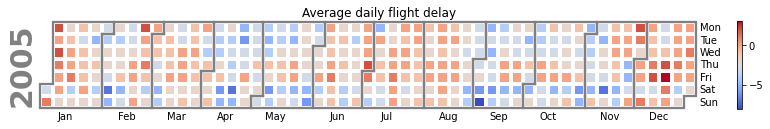

In [19]:
calplot.calplot(meandelay2005["ArrDelay"],linewidth=2.3,
cmap='coolwarm', suptitle=('Average daily flight delay'))

Resetting index as groupby function made 'Dates' into index

In [20]:
meandelay2005 = meandelay2005.reset_index()

Finding the mean of the monthly delays

In [21]:
monthlydelay = dataset[['Date','ArrDelay']].copy()
monthlydelay = monthlydelay.set_index('Date')
monthlydelay = monthlydelay.groupby(pd.Grouper(freq='M')).mean()

# Declare a month name list that is to be converted into a column
months = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Using 'Months' as the column name
# and equating it to the dataframe
monthlydelay['Months'] = months

Bar plot for monthly mean delay

<AxesSubplot:title={'center':'Monthly Average of flight delay (in Mins) - Year 2005'}, xlabel='Months'>

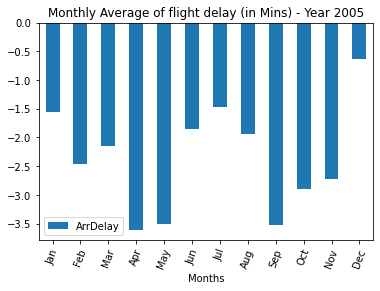

In [22]:
monthlydelay.plot.bar(x="Months", y="ArrDelay", rot=70, title="Monthly Average of flight delay (in Mins) - Year 2005")

Apr - lowest average flight delay. Filter Apr

In [23]:
Apr_Delay = meandelay2005.loc[(meandelay2005['Date'] >= '2005-04-01')
                     & (meandelay2005['Date'] < '2005-04-30')]

# Add days inside
Apr_Delay['Day'] = Apr_Delay.Date.dt.strftime("%A")

C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\1342651767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Apr_Delay['Day'] = Apr_Delay.Date.dt.strftime("%A")


Plot bar

<AxesSubplot:title={'center':'Apr Average of flight delay (in Mins) - Year 2005'}, xlabel='Day'>

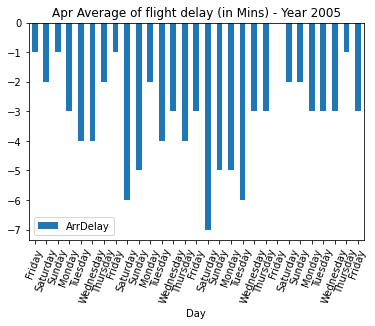

In [24]:
Apr_Delay.plot.bar(x="Day", y="ArrDelay", rot=70, title="Apr Average of flight delay (in Mins) - Year 2005")

Apr 16 lowest average delay of month. Filter for Apr 16

In [25]:
Apr_16 = dataset.loc[(dataset['Date'] == '2005-04-16')]

drop_columns=['Date','Month','DayOfWeek','ArrTime','UniqueCarrier','FlightNum','TailNum','DepDelay','Cancelled']

Apr_16.drop(columns=drop_columns,inplace=True)

Apr_16 = Apr_16.sort_values(by=['DepTime'])

C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\944443026.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Apr_16.drop(columns=drop_columns,inplace=True)


Classifying time of the day

In [26]:
def classify(x):
    if 0 <= x < 1200:
        y = "Morning"
    if 1200 <= x < 1800:
        y = "Afternoon"
    if 1800 <= x < 2400:
        y = "Evening"
    return y

Apr_16['TimeOfDay'] = Apr_16['DepTime'].apply(lambda x: classify(x))

In [27]:
drop_columns=['DepTime']
Apr_16.drop(columns=drop_columns,inplace=True)

# Grouping values together according to time of the day and find the sum of the delay
Apr_16 = Apr_16.groupby(['TimeOfDay']).sum()     # -46939, -45234, -24855
# Negative delay indicates early arrival

Pie chart plot

([<matplotlib.patches.Wedge at 0x1ff53f16490>,
 [Text(0.3974780065161532, 1.2377444139788896, 'Morning'),
  Text(-0.9122926802824799, -0.6145909741470412, 'Afternoon'),
  Text(0.8640945095964636, -0.6806913239385729, 'Evening')])

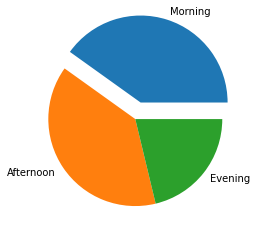

In [29]:
y = ["46939","45234","24855"]
mylabels = ["Morning","Afternoon","Evening"]
# To highlight the biggest portion of the piechart
myexplode = [0.2, 0, 0]
plt.pie(y, labels = mylabels, explode = myexplode)

In [31]:
del y
del myexplode
del mylabels
del Apr_16
del Apr_Delay
del flights_delayed
del months
del monthlydelay
del meandelay2005

NameError: name 'y' is not defined

## **QUESTION 2**

Read in data

In [32]:
planedata = pd.read_csv (r'C:\Users\limzy\dataverse files 0405\plane-data.csv')

plane_records = dataset[['ArrDelay','TailNum']].copy()

Sum of minutes of arrival delay grouped by plane tail number

In [33]:
plane_delay = plane_records.groupby(['TailNum']).sum()

Merge dataframes by tail number

In [34]:
combined_plane_delay = pd.merge(left=plane_delay, right=planedata, left_on='TailNum', right_on='tailnum')

combined_plane_delay.year = combined_plane_delay.year.astype('category')

combined_plane_delay = combined_plane_delay[['ArrDelay','tailnum','year']]
# Remove nan values
combined_plane_delay = combined_plane_delay.dropna()

Group planes according to their issued year and sum up their arrival delay in minutes

In [35]:
combined_plane_delay = combined_plane_delay.groupby(['year']).sum()

combined_plane_delay = combined_plane_delay.reset_index()

Drop unknown year values by index('oooo', 'None'),  its strange to have year 2007 planes appearing in 2005 ('47')

In [36]:
combined_plane_delay = combined_plane_delay.drop([0,47,48])

# Convert year to int
combined_plane_delay['year'] = combined_plane_delay['year'].astype(str).astype(int)
# To convert year(category) to int, it needs to be converted to str first 

Insert Plane age status

In [37]:
plane_conditions = [(combined_plane_delay.year < 1994),
                  (combined_plane_delay.year >= 1994)]
plane_values=['OLD Plane','NEW Plane']        
combined_plane_delay['Plane_Age']=np.select(plane_conditions,plane_values)

Scatter plot

Text(0.5, 0.98, '2005 Arrival delay against age of plane')

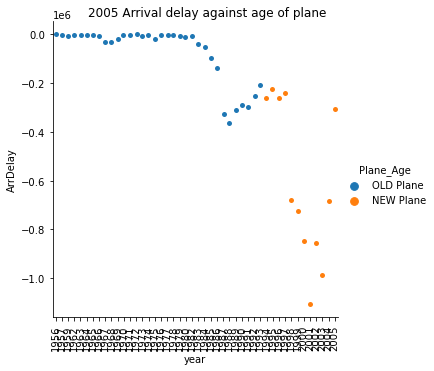

In [38]:
g = sns.catplot(x="year", y="ArrDelay", hue="Plane_Age",  data=combined_plane_delay)
g.set_xticklabels(rotation=90)
g.fig.suptitle('2005 Arrival delay against age of plane')

In [39]:
del g
del plane_conditions
del plane_delay
del plane_records
del plane_values
del planedata
del combined_plane_delay

## **QUESTION 3**

Split data into Quarters of a year

In [40]:
origindep = dataset[['Date', 'Origin']]

Q1 = origindep.loc[(origindep.Date.dt.month==1) | (origindep.Date.dt.month==2) | (origindep.Date.dt.month==3)]
Q2 = origindep.loc[(origindep.Date.dt.month==4) | (origindep.Date.dt.month==5) | (origindep.Date.dt.month==6)]
Q3 = origindep.loc[(origindep.Date.dt.month==7) | (origindep.Date.dt.month==8) | (origindep.Date.dt.month==9)]
Q4 = origindep.loc[(origindep.Date.dt.month==10) | (origindep.Date.dt.month==11) | (origindep.Date.dt.month==12)]

Insert a new column and assign a value of 1(int)

In [41]:
Q1.insert(2, "Count", 1, allow_duplicates=False)
Q2.insert(2, "Count", 1, allow_duplicates=False)
Q3.insert(2, "Count", 1, allow_duplicates=False)
Q4.insert(2, "Count", 1, allow_duplicates=False)

drop_columns=['Date']
Q1.drop(columns=drop_columns,inplace=True)
Q2.drop(columns=drop_columns,inplace=True)
Q3.drop(columns=drop_columns,inplace=True)
Q4.drop(columns=drop_columns,inplace=True)


C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3986106305.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q1.drop(columns=drop_columns,inplace=True)
C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3986106305.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q2.drop(columns=drop_columns,inplace=True)
C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3986106305.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Q3.drop(columns=d

Group by origin and find the top 10 highest count per origin

In [42]:
Q1 = Q1.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q2 = Q2.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q3 = Q3.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()
Q4 = Q4.groupby(['Origin']).sum().sort_values('Count', ascending=False).head(10).reset_index()

### Q1

<AxesSubplot:title={'center':'2005 Q1 top 10 busiest US airport'}, xlabel='Origin'>

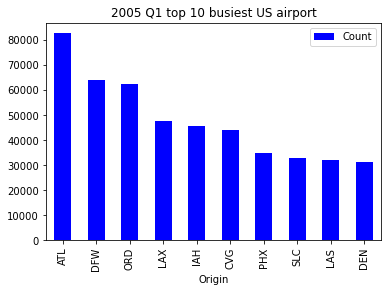

In [43]:
Q1.plot.bar(x = 'Origin', y = 'Count', color = 'blue',
            title = '2005 Q1 top 10 busiest US airport')

### Q2

<AxesSubplot:title={'center':'2005 Q2 top 10 busiest US airport'}, xlabel='Origin'>

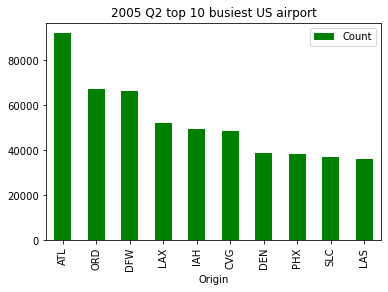

In [44]:
Q2.plot.bar(x = 'Origin', y = 'Count', color = 'green',
            title = '2005 Q2 top 10 busiest US airport')

### Q3

<AxesSubplot:title={'center':'2005 Q3 top 10 busiest US airport'}, xlabel='Origin'>

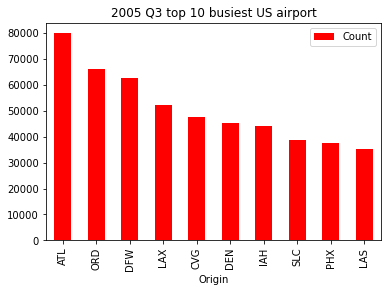

In [45]:
Q3.plot.bar(x = 'Origin', y = 'Count', color = 'red',
            title = '2005 Q3 top 10 busiest US airport')

### Q4

<AxesSubplot:title={'center':'2005 Q4 top 10 busiest US airport'}, xlabel='Origin'>

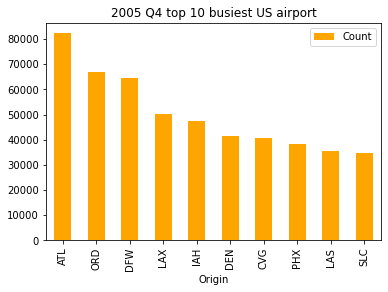

In [46]:
Q4.plot.bar(x = 'Origin', y = 'Count', color = 'orange',
            title = '2005 Q4 top 10 busiest US airport')

In [47]:
del Q1
del Q2
del Q3
del Q4
del origindep

## **QUESTION 4**

Finding the top 3 planes with the highest sum of delay 

In [48]:
highest_delay_flights = dataset[['TailNum', 'ArrDelay']].copy()

top3_highest_delay_flights = highest_delay_flights.groupby(['TailNum']).sum().sort_values('ArrDelay', ascending=False).head(3)

print(top3_highest_delay_flights) #N543US - plane with the highest delay (mins)

         ArrDelay
TailNum          
N543US     2277.0
N373NW     1939.0
N126DL     1879.0


Filter out information from the plane with the highest delay

In [49]:
cascadingflights = dataset[['Date','TailNum', 'DepTime', 'ArrTime',
                            'Origin', 'Dest', 'DepStatus', 'ArrStatus','ArrDelay']].copy()

FlightN543US = cascadingflights.loc[(cascadingflights.TailNum == "N543US") &
                                    (cascadingflights.Date == "2005-12-12")].sort_values('DepTime', ascending=True)

In [50]:
print(FlightN543US)

              Date TailNum  DepTime  ArrTime Origin Dest        DepStatus  \
6717910 2005-12-12  N543US    935.0   1254.0    RSW  DTW  Early Departure   
6985960 2005-12-12  N543US   1405.0   1551.0    DTW  LGA   Late Departure   
6988458 2005-12-12  N543US   1640.0   1819.0    LGA  DTW   Late Departure   
6989972 2005-12-12  N543US   1926.0   2140.0    DTW  MCO   Late Departure   

             ArrStatus  ArrDelay  
6717910   Late Arrival      21.0  
6985960   Late Arrival      21.0  
6988458  Early Arrival      -6.0  
6989972   Late Arrival       6.0  


In [51]:
del cascadingflights
del FlightN543US
del highest_delay_flights
del top3_highest_delay_flights
del drop_columns

## **QUESTION 5**

Required dataframe

In [52]:
r_df = dataset[["Month","DayofMonth", "DayOfWeek","DepTime","CRSArrTime","CRSDepTime","AirTime","Distance","ArrDelay"]]

Setting delayed status

In [53]:
delayed_conditions = [(r_df.ArrDelay <= 0),
                  (r_df.ArrDelay  > 0)]
delayed_values=['Not Delayed','Delayed']        
r_df['DelayedStatus']=np.select(delayed_conditions,delayed_values)

drop_columns=['ArrDelay']

r_df.drop(columns=drop_columns,inplace=True)

C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\943229584.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df['DelayedStatus']=np.select(delayed_conditions,delayed_values)
C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\943229584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df.drop(columns=drop_columns,inplace=True)


Changing numeric variables to lowest possbile intger type

In [54]:
r_df.Month=pd.to_numeric(r_df.Month,downcast='integer')
r_df.DayofMonth=pd.to_numeric(r_df.DayofMonth,downcast='integer')
r_df.DayOfWeek=pd.to_numeric(r_df.DayOfWeek,downcast='integer')
r_df.DepTime=pd.to_numeric(r_df.DepTime,downcast='integer')
r_df.CRSArrTime=pd.to_numeric(r_df.CRSArrTime,downcast='integer')
r_df.CRSDepTime=pd.to_numeric(r_df.CRSDepTime,downcast='integer')
r_df.AirTime=pd.to_numeric(r_df.AirTime,downcast='integer')
r_df.Distance=pd.to_numeric(r_df.Distance,downcast='integer')
r_df.dtypes

C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3201392081.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df.Month=pd.to_numeric(r_df.Month,downcast='integer')
C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3201392081.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_df.DayofMonth=pd.to_numeric(r_df.DayofMonth,downcast='integer')
C:\Users\limzy\AppData\Local\Temp\ipykernel_7152\3201392081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Month              int8
DayofMonth         int8
DayOfWeek          int8
DepTime           int16
CRSArrTime        int16
CRSDepTime        int16
AirTime           int16
Distance          int16
DelayedStatus    object
dtype: object

### Build Machine Learning Model 20/80

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = r_df.drop(columns=['DelayedStatus'])
y = r_df['DelayedStatus']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = DecisionTreeClassifier()
model.fit (X_train, y_train)
predictions = model.predict(X_test) 

score = accuracy_score(y_test, predictions)
score

0.7334923740450892

# End of 2005